In [2]:
raw_counts = pd.read_csv('../data/tcga.brca.rnaseq.unstranded.raw.counts.matrix-2.txt', sep = '\t')
rnaseq_df_init = pd.read_csv('../data/Deconvo2.csv', sep=',', index_col=0)
rnaseq_df_reset = rnaseq_df_init.reset_index()
rnaseq_df = rnaseq_df_reset.rename(columns = {"index": "Case ID"})
rnaseq_df['Case ID'] = rnaseq_df['Case ID'].str.split('-').str[:3].str.join('-')
rnaseq_df['Sample ID'] = rnaseq_df['Case ID'].str.split('-').str[:4].str.join('-')

In [141]:
rnaseq_df_init.shape

(933, 9853)

In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

#md = pd.read_csv('/Users/leojo/Developer/alexandrov_sd_proj/Multiscale_HRD_Classifier/prelim_analysis/data/soft_label.tsv', sep='\t', index_col=0)
# import data
brca_df = pd.read_csv('../data/softlabels_per_Subtype.csv', sep=',', index_col=0)
rnaseq_df_init = pd.read_csv('../data/tcga.brca.rnaseq.unstranded.fpkm.counts.matrix.txt', sep='\t', index_col=0)
# rnaseq_df_reset = rnaseq_df_init.reset_index()
# rnaseq_df = rnaseq_df_reset.rename(columns = {"index": "Case ID"})
# rnaseq_df['Case ID'] = rnaseq_df['Case ID'].str.split('-').str[:3].str.join('-')
# rnaseq_df['Sample ID'] = rnaseq_df['Case ID'].str.split('-').str[:4].str.join('-')


# Drop rows where event.BRCA1 is '1'
brca_df_filtered = brca_df[brca_df['event.BRCA1'] != '1']

# Drop rows where event.BRCA2 is 'Bi-allelic-undetermined'
brca_df_filtered = brca_df_filtered[brca_df_filtered['event.BRCA2'] != 'Bi-allelic-undetermined']
#brca_df_filtered = brca_df_filtered[brca_df_filtered['event.BRCA2'] == '0']

# Drop rows where event.PALB2 is '2'
brca_df_filtered = brca_df_filtered[brca_df_filtered['event.PALB2'] != '2']

# keep common samples

#idenfity the common samples

# Extract sample IDs from each dataframe
rnaseq_samples = set(rnaseq_df['Case ID'])
brca_samples = set(brca_df_filtered.index)

# Find the intersection of all sample IDs
common_samples = rnaseq_samples.intersection(brca_samples)

# Print the number of common samples
print("\nNumber of common samples:", len(common_samples))

# Drop samples that are not common in all three dataframes
rnaseq_df_common = rnaseq_df[rnaseq_df['Case ID'].isin(common_samples)]
rnaseq_df_common.rename(columns=map, inplace=True)
brca_df_common = brca_df_filtered[brca_df_filtered.index.isin(common_samples)]

# Print the shapes of the new dataframes
print("rnaseq_df_common:", rnaseq_df_common.shape)
print("brca_df_common:", brca_df_common.shape)
# Check for duplicates in rnaseq_df_common's Case ID
print("Duplicate Case IDs in rnaseq_df:", rnaseq_df_common['Case ID'].duplicated().sum())

# Drop duplicates in rnaseq_df_common if any
rnaseq_df_common = rnaseq_df_common.drop_duplicates(subset=['Case ID'])

# Verify the shapes after removing duplicates
print("\nAfter removing duplicates:")
print("rnaseq_df_common:", rnaseq_df_common.shape)
print("brca_df_common:", brca_df_common.shape)

# Verify that we have exactly the same samples in both dataframes
rnaseq_samples = set(rnaseq_df_common['Case ID'])
brca_samples = set(brca_df_common.index)
print("\nSamples match:", rnaseq_samples == brca_samples)
print("Number of samples in each:", len(rnaseq_samples), len(brca_samples))

rnaseq_df_common.set_index('Case ID', inplace=True)
rnaseq_df_common.head()

# Sort the samples in both dataframes by index
rnaseq_df_common = rnaseq_df_common.sort_index()
brca_df_common = brca_df_common.sort_index()

# Verify indices match exactly
indices_match = (rnaseq_df_common.index == brca_df_common.index).all()
print("\nIndices match exactly:", indices_match)

print(brca_df_common.shape)
brca_df_common.head()
print(rnaseq_df_common.shape)
rnaseq_df_common.head()

# filter to top 2 percent of differentially expressed genes
deseq_results=pd.read_csv('../data/basic_deseq_HRD_contrast.csv', index_col=0)
#deseq_results = deseq_results_init.loc[['BRCA1', 'BRCA2', 'PALB2', 'RAD51C', 'PARP1', 'PARP2', 'PARP3']]



deseq_results.head()

# Filter columns in rna_seq_df based on deseq_results row indices
deseq_filtered_rna_seq_df = rnaseq_df_common[[col for col in rnaseq_df_common.columns if col in deseq_results.index]]
print(deseq_filtered_rna_seq_df.shape)
deseq_filtered_rna_seq_df.head()
#Filter to top 2% of all protein genes
#drop non-protein coding genes

# Step 1: Filter for protein coding genes (from your original code)
#columns_to_keep = ['Sample ID', 'Sample Type']
columns_to_keep = ['Sample ID']
gene_columns = [col for col in rnaseq_df_common.columns if col not in columns_to_keep]
protein_coding_cols = [col for col in gene_columns if 'protein_coding' in col]
final_columns = columns_to_keep + protein_coding_cols
pcg_rnaseq_df_filtered = rnaseq_df_common[final_columns]


# Step 2: Calculate mean expression for each gene
# First, separate metadata columns from gene expression columns
gene_expression = pcg_rnaseq_df_filtered[protein_coding_cols]
metadata = pcg_rnaseq_df_filtered[columns_to_keep]


# Calculate mean expression for each gene
gene_means = gene_expression.mean(axis=0)

# Calculate number of genes to keep (top 2%)
n_genes_to_keep = 200

# Get the column names (genes) with highest mean expression
top_genes = gene_means.nlargest(n_genes_to_keep).index

# Create final dataframe with metadata and top genes
pcg_200_with_metadata = pd.concat([metadata, pcg_rnaseq_df_filtered[top_genes]], axis=1)

# Create final dataframe with only top genes
pcg_200 = pcg_rnaseq_df_filtered[top_genes]

# Print information about the filtering
print("Original number of protein coding genes:", len(protein_coding_cols))
print("Number of top genes kept (2%):", n_genes_to_keep)
print("\nDataframe shapes:")
print("Original:", rnaseq_df.shape)
print("After protein coding filter:", pcg_rnaseq_df_filtered.shape)
print("Final (with top 2% genes) with metadata:", pcg_200_with_metadata.shape)
print("Final (with top 2% genes):", pcg_200.shape)



# Optional: Show summary statistics of the mean expression values
print("\nMean expression summary for top genes:")
print(gene_means[top_genes].describe())

# Save results to new dataframe
rnaseq_df_top_genes = pcg_200

# Optional: verify that our key columns are still present
print("\nChecking if key columns are present:")
for col in columns_to_keep:
    print(f"{col} present: {col in rnaseq_df_top_genes.columns}")
rnaseq_df_top_genes.head()
#files to use for training/testing

#top 2% of expressed protein coding genes
rnaseq_df_top_genes.head()
print(rnaseq_df_top_genes.shape)

#top 2% of differentially expressed genes
deseq_filtered_rna_seq_df.head()
print(deseq_filtered_rna_seq_df.shape)

#metadata with soft labels
brca_df_common.head()
print(brca_df_common.shape)



Number of common samples: 857


/var/folders/vh/rzymgl1d6c79q_4lhgmys8cm0000gn/T/ipykernel_96500/4247523323.py:45: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



rnaseq_df_common: (857, 9855)
brca_df_common: (857, 40)
Duplicate Case IDs in rnaseq_df: 0

After removing duplicates:
rnaseq_df_common: (857, 9855)
brca_df_common: (857, 40)

Samples match: True
Number of samples in each: 857 857

Indices match exactly: True
(857, 40)
(857, 9854)
(857, 6403)
Original number of protein coding genes: 0
Number of top genes kept (2%): 200

Dataframe shapes:
Original: (933, 9855)
After protein coding filter: (857, 1)
Final (with top 2% genes) with metadata: (857, 1)
Final (with top 2% genes): (857, 0)

Mean expression summary for top genes:
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
dtype: float64

Checking if key columns are present:
Sample ID present: False
(857, 0)
(857, 6403)
(857, 40)


In [159]:
rnaseq_df_init

,Case ID,Sample ID,Sample Type,ENSG00000000003.15|TSPAN6|protein_coding,ENSG00000000005.6|TNMD|protein_coding,ENSG00000000419.13|DPM1|protein_coding,ENSG00000000457.14|SCYL3|protein_coding,ENSG00000000460.17|C1orf112|protein_coding,ENSG00000000938.13|FGR|protein_coding,ENSG00000000971.16|CFH|protein_coding,...,ENSG00000288661.1|AL451106.1|protein_coding,ENSG00000288662.1|AC092910.4|lncRNA,ENSG00000288663.1|AC073611.1|lncRNA,ENSG00000288665.1|AC136977.1|lncRNA,ENSG00000288667.1|AC078856.1|lncRNA,ENSG00000288669.1|AC008763.4|protein_coding,ENSG00000288670.1|AL592295.6|lncRNA,ENSG00000288671.1|AC006486.3|protein_coding,ENSG00000288674.1|AL391628.1|protein_coding,ENSG00000288675.1|AP006621.6|protein_coding
0,TCGA-E9-A1RH,TCGA-E9-A1RH-01A,Primary Tumor,1.0276,0.0000,74.2709,1.3816,1.6749,1.4166,5.2410,...,0.0,0.0000,0.0177,0.0,0.0000,0.0000,1.8073,0.0,0.0000,0.1285
1,TCGA-C8-A26W,TCGA-C8-A26W-01A,Primary Tumor,13.2684,0.1250,37.9298,3.7360,3.1045,2.4799,7.4851,...,0.0,0.0000,0.0847,0.0,0.0000,0.0036,3.4634,0.0,0.0074,0.3801
2,TCGA-E9-A1RH,TCGA-E9-A1RH-11A,Solid Tissue Normal,12.8007,8.4777,21.6363,2.4554,0.5852,2.7533,27.4655,...,0.0,0.2708,0.0456,0.0,0.2664,0.0041,5.8816,0.0,0.0372,0.1064
3,TCGA-AO-A0JJ,TCGA-AO-A0JJ-01A,Primary Tumor,14.8681,2.2172,27.8838,4.3170,1.7847,3.7167,9.6630,...,0.0,0.0000,0.0261,0.0,0.0000,0.0000,3.2723,0.0,0.0058,0.2546
4,TCGA-BH-A0HO,TCGA-BH-A0HO-01A,Primary Tumor,0.8430,0.0798,22.1105,3.9971,0.9805,2.4742,3.8185,...,0.0,0.0000,0.0253,0.0,0.0000,0.0000,3.1233,0.0,0.0041,0.4599
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1226,TCGA-BH-A0AU,TCGA-BH-A0AU-01A,Primary Tumor,6.4837,0.7204,37.6328,4.3130,1.9342,1.6600,6.3929,...,0.0,0.0000,0.1045,0.0,0.0000,0.0000,6.5196,0.0,0.0066,0.0886
1227,TCGA-A8-A09G,TCGA-A8-A09G-01A,Primary Tumor,7.6167,0.3250,33.0678,6.5885,2.3227,1.8351,5.2748,...,0.0,0.0000,0.0485,0.0,0.0000,0.0000,2.8716,0.0,0.0121,0.2942
1228,TCGA-E2-A14X,TCGA-E2-A14X-01A,Primary Tumor,20.7009,0.1777,39.0361,6.4451,2.7007,2.9901,5.2498,...,0.0,0.0000,0.0900,0.0,0.0000,0.0000,5.1344,0.0,0.0223,0.1917
1229,TCGA-HN-A2OB,TCGA-HN-A2OB-01A,Primary Tumor,20.2782,0.6577,18.8827,3.7280,1.0939,1.9115,4.1113,...,0.0,0.0000,0.0813,0.0,0.7234,0.0000,3.3211,0.0,0.0229,0.3809


In [5]:
genes_validation = pd.read_csv('../data/validation/CCLE_RNAseq_genes_counts_20180929.gct', sep="\t", skiprows=2)
# Drop the 'Ensembl IDs' column
genes_validation_transposed = genes_validation.drop(columns=['Name'])

# Set the 'Description' column as the new header (column names)
genes_validation_transposed = genes_validation_transposed.set_index('Description').transpose()

#genes_validation_transposed_sorted = genes_validation_transposed.sort_index(axis = 1)

In [6]:
genes_validation_transposed

Description,DDX11L1,WASH7P,MIR1302-11,FAM138A,OR4G4P,OR4G11P,OR4F5,RP11-34P13.7,CICP27,AL627309.1,...,MT-ND4,MT-TH,MT-TS2,MT-TL2,MT-ND5,MT-ND6,MT-TE,MT-CYB,MT-TT,MT-TP
22RV1_PROSTATE,12.0,1340.0,4.0,6.0,0.0,4.0,6.0,21.0,47.0,756.0,...,1247652.0,7.0,7.0,11.0,554396.0,124017.0,42.0,695276.0,2.0,4.0
2313287_STOMACH,8.0,821.0,1.0,3.0,2.0,5.0,8.0,10.0,39.0,756.0,...,1222392.0,4.0,3.0,4.0,376693.0,112857.0,23.0,457726.0,0.0,2.0
253JBV_URINARY_TRACT,8.0,678.0,3.0,2.0,3.0,3.0,1.0,3.0,67.0,45.0,...,1058721.0,5.0,4.0,16.0,407998.0,136078.0,11.0,250709.0,5.0,11.0
253J_URINARY_TRACT,6.0,677.0,3.0,4.0,1.0,5.0,4.0,6.0,45.0,28.0,...,2155512.0,8.0,9.0,16.0,724957.0,254975.0,33.0,589478.0,7.0,21.0
42MGBA_CENTRAL_NERVOUS_SYSTEM,2.0,884.0,2.0,1.0,1.0,1.0,2.0,6.0,24.0,15.0,...,686299.0,2.0,6.0,4.0,262388.0,106503.0,22.0,316056.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YD8_UPPER_AERODIGESTIVE_TRACT,14.0,558.0,6.0,8.0,3.0,7.0,17.0,3.0,54.0,34.0,...,346531.0,7.0,1.0,13.0,234611.0,56555.0,15.0,144686.0,10.0,10.0
YH13_CENTRAL_NERVOUS_SYSTEM,11.0,309.0,3.0,7.0,5.0,6.0,4.0,3.0,43.0,51.0,...,242210.0,6.0,2.0,1.0,107441.0,37417.0,12.0,85061.0,14.0,4.0
YKG1_CENTRAL_NERVOUS_SYSTEM,5.0,811.0,1.0,0.0,4.0,0.0,1.0,2.0,20.0,71.0,...,550207.0,5.0,6.0,22.0,244139.0,55576.0,23.0,242084.0,0.0,1.0
ZR751_BREAST,13.0,500.0,6.0,10.0,3.0,10.0,4.0,17.0,64.0,875.0,...,252725.0,0.0,1.0,2.0,129740.0,42767.0,9.0,89457.0,3.0,8.0


In [7]:
#deseq_filtered_rna_seq_df_sort = deseq_filtered_rna_seq_df.sort_index(axis=1)

In [8]:
#deseq_filtered_rna_seq_df_sort

In [9]:
#check unique cols 
assert deseq_filtered_rna_seq_df.columns.is_unique
assert genes_validation_transposed.columns.is_unique

AssertionError: 

In [10]:
# drop duplicates
genes_validation_transposed_sorted = genes_validation_transposed.loc[:, ~genes_validation_transposed.columns.duplicated()]


In [11]:
assert genes_validation_transposed_sorted.columns.is_unique

In [12]:
# Step 1: Find common columns
common_columns = set(deseq_filtered_rna_seq_df.columns).intersection(genes_validation_transposed.columns)

# Step 2: Filter each dataframe to keep only common columns
deseq_filtered_rna_seq_df_common = deseq_filtered_rna_seq_df[list(common_columns)]
genes_validation_common = genes_validation_transposed_sorted[list(common_columns)]

# Display the resulting shapes to confirm
print("Shape of filtered deseq_filtered_rna_seq_df:", deseq_filtered_rna_seq_df_common.shape)
print("Shape of filtered genes_validation:", genes_validation_common.shape)


Shape of filtered deseq_filtered_rna_seq_df: (857, 6347)
Shape of filtered genes_validation: (1019, 6347)


In [13]:
sorted(common_columns)

['A1BG',
 'A2M',
 'AAAS',
 'AAGAB',
 'AAMDC',
 'AARD',
 'AARS2',
 'AATF',
 'ABAT',
 'ABCA2',
 'ABCA3',
 'ABCA7',
 'ABCB10',
 'ABCB8',
 'ABCC1',
 'ABCC10',
 'ABCC11',
 'ABCC3',
 'ABCD3',
 'ABCD4',
 'ABCE1',
 'ABCF1',
 'ABCF2',
 'ABCF3',
 'ABCG1',
 'ABHD1',
 'ABHD13',
 'ABHD14A',
 'ABHD14B',
 'ABHD17A',
 'ABHD17B',
 'ABHD2',
 'ABI1',
 'ABI2',
 'ABR',
 'ABRACL',
 'ABT1',
 'ABTB1',
 'ACAA1',
 'ACAA2',
 'ACAD10',
 'ACAD8',
 'ACAD9',
 'ACADS',
 'ACADSB',
 'ACADVL',
 'ACAN',
 'ACAP2',
 'ACAT2',
 'ACBD4',
 'ACD',
 'ACIN1',
 'ACO2',
 'ACOT13',
 'ACOT2',
 'ACOT4',
 'ACOT7',
 'ACOT8',
 'ACOX1',
 'ACOX2',
 'ACOX3',
 'ACP1',
 'ACP5',
 'ACP6',
 'ACSF2',
 'ACSL1',
 'ACSL5',
 'ACSS1',
 'ACSS2',
 'ACTB',
 'ACTG1',
 'ACTG2',
 'ACTL10',
 'ACTL6A',
 'ACTN1',
 'ACTN4',
 'ACTR2',
 'ACTR3',
 'ACTR3B',
 'ACTR3C',
 'ACTR5',
 'ACTR6',
 'ACTR8',
 'ACVR1B',
 'ACY1',
 'ACYP1',
 'ACYP2',
 'ADAL',
 'ADAM12',
 'ADAM17',
 'ADAM8',
 'ADAM9',
 'ADAMTS15',
 'ADAMTSL4',
 'ADARB1',
 'ADAT3',
 'ADCY1',
 'ADCY3',
 'ADCY4',
 

In [14]:
breast_filt = genes_validation_common[genes_validation_common.index.str.contains('BREAST')]

In [15]:
print("Shape of filtered genes_validation:", breast_filt.shape)

Shape of filtered genes_validation: (51, 6347)


In [16]:
breast_filt_idx = breast_filt.set_index(breast_filt.index.str.split('_').str[0])

In [ ]:
#breast_filt_idx

In [17]:
# Ensure column orders match
assert list(deseq_filtered_rna_seq_df_common.columns) == list(breast_filt.columns), "Column order mismatch!"


In [18]:
# Check if all column names are identical
assert set(deseq_filtered_rna_seq_df_common.columns) == set(genes_validation_common.columns), "Column names mismatch!"

In [19]:
sorted(breast_filt.columns)

['A1BG',
 'A2M',
 'AAAS',
 'AAGAB',
 'AAMDC',
 'AARD',
 'AARS2',
 'AATF',
 'ABAT',
 'ABCA2',
 'ABCA3',
 'ABCA7',
 'ABCB10',
 'ABCB8',
 'ABCC1',
 'ABCC10',
 'ABCC11',
 'ABCC3',
 'ABCD3',
 'ABCD4',
 'ABCE1',
 'ABCF1',
 'ABCF2',
 'ABCF3',
 'ABCG1',
 'ABHD1',
 'ABHD13',
 'ABHD14A',
 'ABHD14B',
 'ABHD17A',
 'ABHD17B',
 'ABHD2',
 'ABI1',
 'ABI2',
 'ABR',
 'ABRACL',
 'ABT1',
 'ABTB1',
 'ACAA1',
 'ACAA2',
 'ACAD10',
 'ACAD8',
 'ACAD9',
 'ACADS',
 'ACADSB',
 'ACADVL',
 'ACAN',
 'ACAP2',
 'ACAT2',
 'ACBD4',
 'ACD',
 'ACIN1',
 'ACO2',
 'ACOT13',
 'ACOT2',
 'ACOT4',
 'ACOT7',
 'ACOT8',
 'ACOX1',
 'ACOX2',
 'ACOX3',
 'ACP1',
 'ACP5',
 'ACP6',
 'ACSF2',
 'ACSL1',
 'ACSL5',
 'ACSS1',
 'ACSS2',
 'ACTB',
 'ACTG1',
 'ACTG2',
 'ACTL10',
 'ACTL6A',
 'ACTN1',
 'ACTN4',
 'ACTR2',
 'ACTR3',
 'ACTR3B',
 'ACTR3C',
 'ACTR5',
 'ACTR6',
 'ACTR8',
 'ACVR1B',
 'ACY1',
 'ACYP1',
 'ACYP2',
 'ADAL',
 'ADAM12',
 'ADAM17',
 'ADAM8',
 'ADAM9',
 'ADAMTS15',
 'ADAMTSL4',
 'ADARB1',
 'ADAT3',
 'ADCY1',
 'ADCY3',
 'ADCY4',
 

In [20]:
sorted(deseq_filtered_rna_seq_df_common.columns)

['A1BG',
 'A2M',
 'AAAS',
 'AAGAB',
 'AAMDC',
 'AARD',
 'AARS2',
 'AATF',
 'ABAT',
 'ABCA2',
 'ABCA3',
 'ABCA7',
 'ABCB10',
 'ABCB8',
 'ABCC1',
 'ABCC10',
 'ABCC11',
 'ABCC3',
 'ABCD3',
 'ABCD4',
 'ABCE1',
 'ABCF1',
 'ABCF2',
 'ABCF3',
 'ABCG1',
 'ABHD1',
 'ABHD13',
 'ABHD14A',
 'ABHD14B',
 'ABHD17A',
 'ABHD17B',
 'ABHD2',
 'ABI1',
 'ABI2',
 'ABR',
 'ABRACL',
 'ABT1',
 'ABTB1',
 'ACAA1',
 'ACAA2',
 'ACAD10',
 'ACAD8',
 'ACAD9',
 'ACADS',
 'ACADSB',
 'ACADVL',
 'ACAN',
 'ACAP2',
 'ACAT2',
 'ACBD4',
 'ACD',
 'ACIN1',
 'ACO2',
 'ACOT13',
 'ACOT2',
 'ACOT4',
 'ACOT7',
 'ACOT8',
 'ACOX1',
 'ACOX2',
 'ACOX3',
 'ACP1',
 'ACP5',
 'ACP6',
 'ACSF2',
 'ACSL1',
 'ACSL5',
 'ACSS1',
 'ACSS2',
 'ACTB',
 'ACTG1',
 'ACTG2',
 'ACTL10',
 'ACTL6A',
 'ACTN1',
 'ACTN4',
 'ACTR2',
 'ACTR3',
 'ACTR3B',
 'ACTR3C',
 'ACTR5',
 'ACTR6',
 'ACTR8',
 'ACVR1B',
 'ACY1',
 'ACYP1',
 'ACYP2',
 'ADAL',
 'ADAM12',
 'ADAM17',
 'ADAM8',
 'ADAM9',
 'ADAMTS15',
 'ADAMTSL4',
 'ADARB1',
 'ADAT3',
 'ADCY1',
 'ADCY3',
 'ADCY4',
 

In [21]:
# Compare values to ensure they are identical
is_equal = deseq_filtered_rna_seq_df_common.equals(genes_validation_common)
if is_equal:
    print("All feature columns are in the same order and have identical values.")
else:
    print("There is a mismatch in feature values or column order.")

There is a mismatch in feature values or column order.


In [22]:
breast_filt = breast_filt[deseq_filtered_rna_seq_df_common.columns]

In [23]:
# Ensure column orders match
assert list(deseq_filtered_rna_seq_df_common.columns) == list(breast_filt.columns), "Column order mismatch!"

In [24]:
differences = set(deseq_filtered_rna_seq_df_common) - set(breast_filt)
differences

set()

In [246]:
ispy2_expr = pd.read_csv('../data/validation/GSE173839_ISPY2_AgilentGeneExp_durvaPlusCtr_FFPE_meanCol_geneLevel_n105.txt', sep = '\t')
ispy2_expr.set_index('GeneName', inplace=True)
ispy_probe_transposed = ispy2_expr.T
ispy_probe_transposed.sort_index(inplace=True)
ispy_probe_transposed.dropna(inplace=True)

common_columns_ispy = ispy_probe_transposed.columns.intersection(deseq_filtered_rna_seq_df_common.columns)

# Convert to a list
deseq_filtered_rna_seq_df_common = deseq_filtered_rna_seq_df_common[list(common_columns_ispy)]


Training models on differentially expressed genes:


/Users/johnsmith/miniconda3/envs/HRDclass/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



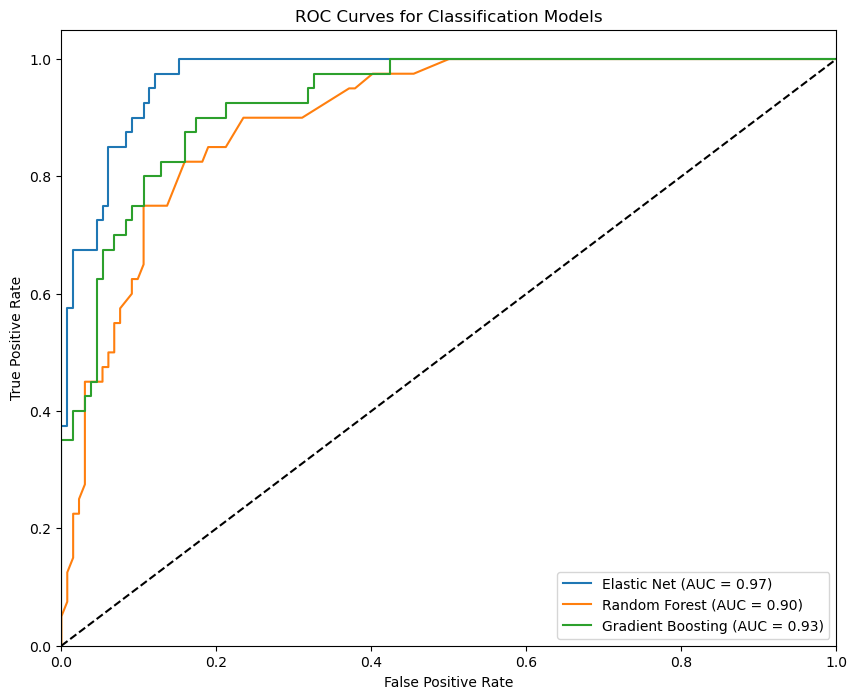


Results for differentially expressed genes:

Elastic Net:
AUC: 0.971

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.95       132
           1       0.81      0.85      0.83        40

    accuracy                           0.92       172
   macro avg       0.88      0.89      0.89       172
weighted avg       0.92      0.92      0.92       172


Confusion Matrix:
[[124   8]
 [  6  34]]

Random Forest:
AUC: 0.900

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.94      0.90       132
           1       0.70      0.47      0.57        40

    accuracy                           0.83       172
   macro avg       0.78      0.71      0.73       172
weighted avg       0.82      0.83      0.82       172


Confusion Matrix:
[[124   8]
 [ 21  19]]

Gradient Boosting:
AUC: 0.928

Classification Report:
              precision    recall  f1-score   support

       

In [247]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression, ElasticNet
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

baby = None

# Data Preprocessing Function
def preprocess_data(X, y, task='classification'):
    # Encode categorical labels
    if task == 'classification':
        le = LabelEncoder()
        y = le.fit_transform(y)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train, y_test

# Model Training & Evaluation Function for Classification
def train_evaluate_classification_models(X_train, X_test, y_train, y_test):
    global baby
    models = {
        'Elastic Net': LogisticRegression(penalty='elasticnet', solver='saga', 
                                        l1_ratio=0.5, max_iter=1000),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42)
    }
    
    results = {}
    plt.figure(figsize=(10, 8))
    
    for name, model in models.items():
        # Train model
        model.fit(X_train, y_train)
        
        # Get predictions
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        y_pred = model.predict(X_test)
        
        # Calculate metrics
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        
        # Plot ROC curve
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
        
        # Store results
        results[name] = {
            'AUC': roc_auc,
            'Confusion Matrix': confusion_matrix(y_test, y_pred),
            'Classification Report': classification_report(y_test, y_pred)
        }

        if name == 'Elastic Net':
            baby = model
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Classification Models')
    plt.legend(loc="lower right")
    plt.show()
    
    return results

# Main execution
def main():
    # # For top 2% expressed genes
    # print("Training models on top 2% expressed genes:")
    
    # # Classification
    # X_train_top, X_test_top, y_train_top, y_test_top = preprocess_data(
    #     rnaseq_df_top_genes, brca_df_common['HRD_status_base'], task='classification'
    # )
    
    # results_top = train_evaluate_classification_models(
    #     X_train_top, X_test_top, y_train_top, y_test_top
    # )
    
    # For differentially expressed genes
    print("\nTraining models on differentially expressed genes:")
    
    X_train_de, X_test_de, y_train_de, y_test_de = preprocess_data(
        deseq_filtered_rna_seq_df_common, brca_df_common['HRD_status_base'], task='classification'
    )
    
    results_de = train_evaluate_classification_models(
        X_train_de, X_test_de, y_train_de, y_test_de
    )
    
    # # Print results
    # print("\nResults for top 2% expressed genes:")
    # for model_name, metrics in results_top.items():
    #     print(f"\n{model_name}:")
    #     print(f"AUC: {metrics['AUC']:.3f}")
    #     print("\nClassification Report:")
    #     print(metrics['Classification Report'])
    #     print("\nConfusion Matrix:")
    #     print(metrics['Confusion Matrix'])
    
    print("\nResults for differentially expressed genes:")
    for model_name, metrics in results_de.items():
        print(f"\n{model_name}:")
        print(f"AUC: {metrics['AUC']:.3f}")
        print("\nClassification Report:")
        print(metrics['Classification Report'])
        print("\nConfusion Matrix:")
        print(metrics['Confusion Matrix'])

# For regression task on Confidence values
def train_evaluate_regression_models(X_train, X_test, y_train, y_test):
    models = {
        'Elastic Net': ElasticNet(random_state=42),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(random_state=42)
    }
    
    results = {}
    
    for name, model in models.items():
        # Train model
        model.fit(X_train, y_train)
        
        # Get predictions
        y_pred = model.predict(X_test)
        
        # Calculate metrics
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        # Store results
        results[name] = {
            'MSE': mse,
            'R2': r2,
            'Model': model
        }
        
        # Plot actual vs predicted
        plt.figure(figsize=(8, 6))
        plt.scatter(y_test, y_pred, alpha=0.5)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
        plt.xlabel('Actual Confidence')
        plt.ylabel('Predicted Confidence')
        plt.title(f'{name} - Actual vs Predicted')
        plt.show()
    
    return results

# # Run regression models
# def run_regression():
#     print("\nTraining regression models for Confidence prediction:")
    
#     # For top 2% expressed genes
#     X_train_top, X_test_top, y_train_top, y_test_top = preprocess_data(
#         rnaseq_df_top_genes, brca_df_common['Confidence'], task='regression'
#     )
    
#     results_top_reg = train_evaluate_regression_models(
#         X_train_top, X_test_top, y_train_top, y_test_top
#     )
    
#     print("\nRegression Results for top 2% expressed genes:")
#     for model_name, metrics in results_top_reg.items():
#         print(f"\n{model_name}:")
#         print(f"MSE: {metrics['MSE']:.6f}")
#         print(f"R2: {metrics['R2']:.3f}")

googoog = main()
#run_regression()

In [26]:
baby

LogisticRegression(l1_ratio=0.5, max_iter=1000, penalty='elasticnet',
                   solver='saga')

# CCLE

In [29]:
predictions = baby.predict(breast_filt)
# Display or save the predictions
print(predictions)

# Optionally, add predictions as a new column to the DataFrame
breast_filt['predictions'] = predictions

[0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


/Users/johnsmith/miniconda3/envs/HRDclass/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [35]:
breast_filt.index = breast_filt.index.str.split('_').str[0]

In [37]:
drug_resp = pd.read_csv('../data/validation/BRCA_IC_Sat Jan 11 20_40_55 2025.csv')
parps = ['Olaparib', 'Talazoparib', 'Niraparib', 'Rucaparib', 'Veliparib']
parpi_resp = drug_resp[drug_resp['Drug Name'].isin(parps)]
parpi_resp_filt = parpi_resp[['Drug Name', 'Cell Line Name', 'IC50']]
parpi_resp_filt['log10IC50'] = np.log10(parpi_resp_filt['IC50'])
parpi_resp_filt

/Users/johnsmith/miniconda3/envs/HRDclass/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/vh/rzymgl1d6c79q_4lhgmys8cm0000gn/T/ipykernel_96500/858282350.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parpi_resp_filt['log10IC50'] = np.log10(parpi_resp_filt['IC50'])


,Drug Name,Cell Line Name,IC50,log10IC50
0,Olaparib,HCC1954,4.017502,0.603956
1,Olaparib,HCC1143,5.307956,0.724927
2,Olaparib,HCC1187,4.459187,0.649256
3,Olaparib,HCC1395,3.496354,0.543615
4,Olaparib,HCC1599,4.608563,0.663565
...,...,...,...,...
384,Talazoparib,HDQ-P1,3.718242,0.570338
385,Talazoparib,JIMT-1,4.466165,0.649935
386,Talazoparib,HCC1500,5.377461,0.730577
387,Talazoparib,YMB-1-E,2.975015,0.473489


In [38]:
from scipy.stats import ttest_ind
import plotly_express as px
stats = {}
for drug in parpi_resp['Drug Name'].unique():
    #print(drug)
    d = parpi_resp_filt[parpi_resp_filt['Drug Name'] == drug]
    d['Cell Line Name'] = d['Cell Line Name'].str.replace('-', '', regex=False)
    merged = d.merge(breast_filt.reset_index(), left_on='Cell Line Name', right_on='index')

    merged = merged.sort_values(by='Cell Line Name')

    group_0 = merged.loc[merged['predictions'] == 0, 'log10IC50']
    group_1 = merged.loc[merged['predictions'] == 1, 'log10IC50']


    t_stat, p_value = ttest_ind(group_0, group_1, equal_var = False)
    stats[drug] = p_value    
stats

/var/folders/vh/rzymgl1d6c79q_4lhgmys8cm0000gn/T/ipykernel_96500/4028709290.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['Cell Line Name'] = d['Cell Line Name'].str.replace('-', '', regex=False)
/var/folders/vh/rzymgl1d6c79q_4lhgmys8cm0000gn/T/ipykernel_96500/4028709290.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['Cell Line Name'] = d['Cell Line Name'].str.replace('-', '', regex=False)
/var/folders/vh/rzymgl1d6c79q_4lhgmys8cm0000gn/T/ipykernel_96500/4028709290.py:7: SettingWithCopyWarning

{'Olaparib': 0.5921067194185441,
 'Veliparib': 0.4291800417811504,
 'Rucaparib': 0.39079709926137907,
 'Niraparib': 0.8192529416086446,
 'Talazoparib': nan}

In [39]:
merged = parpi_resp_filt.merge(breast_filt.reset_index(), left_on='Cell Line Name', right_on='index')
px.strip(merged, x = 'Drug Name', y = 'IC50', color = 'predictions')

# ISPY

In [180]:
common_columns_ispy = ispy_probe_transposed.columns.intersection(deseq_filtered_rna_seq_df_common.columns)

# Convert to a list
ispy_probe_transposed_filt = ispy_probe_transposed[list(common_columns_ispy)]



In [187]:
ispy2_response = pd.read_csv('../data/validation/GSE173839_ISPY2_DurvalumabOlaparibArm_biomarkers.csv')
ispy2_response.loc[ispy2_response["pCR.status"] == -1, "pCR.status"] = (
    0  # present in control arm
)

ispy2_response.sort_values(by='ResearchID', inplace=True)
ispy2_response["ResearchID"] = ispy2_response["ResearchID"].astype(str).str.strip()
ispy2_expr = ispy2_expr[ispy2_response["ResearchID"]]

In [196]:
scaler = StandardScaler()

# Fit and transform the data
scaled_data = scaler.fit_transform(ispy_probe_transposed_filt)

In [201]:
ispy_probe_transposed_filt

GeneName,A1BG,A2M,AAAS,AAGAB,AAMDC,AARD,AARS2,AATF,ABAT,ABCA2,...,ZSWIM6,ZSWIM7,ZSWIM8,ZW10,ZWILCH,ZWINT,ZXDC,ZYG11A,ZYG11B,ZYX
102596,12.140,8.231,9.096,8.448,8.926,6.171,7.988,8.107,5.719,8.056,...,9.856,7.258,8.148,7.068,6.504,8.790,7.767,6.736,6.802,9.972
111922,11.580,9.978,8.877,9.173,8.692,6.329,8.315,7.712,5.885,9.010,...,9.657,7.744,9.097,6.992,6.825,7.839,6.948,5.600,6.732,11.000
115724,10.820,10.390,8.672,8.880,9.297,7.419,8.323,7.130,5.397,8.982,...,10.030,6.964,8.764,5.182,6.414,9.675,6.591,5.028,6.132,11.350
123591,11.110,8.214,8.750,8.967,8.027,8.955,8.163,7.397,6.128,8.716,...,9.503,7.563,7.858,6.702,6.451,8.668,7.118,6.971,7.059,11.040
134956,10.950,9.422,9.951,9.820,8.964,6.489,8.059,8.422,9.038,9.049,...,10.110,7.344,8.386,6.594,6.926,8.845,7.211,6.153,6.733,10.560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
944184,13.450,9.795,9.553,9.984,10.150,7.379,8.342,7.093,7.435,8.844,...,9.336,7.395,7.996,5.947,6.610,9.070,7.984,5.320,6.649,10.420
965961,9.102,9.082,8.908,9.535,9.316,9.434,7.781,7.207,5.911,9.050,...,9.441,7.787,8.580,6.190,6.837,8.579,7.064,5.536,7.080,11.000
979809,10.190,10.630,9.145,9.084,9.673,7.870,8.191,6.623,6.117,9.390,...,9.584,7.304,8.539,6.703,6.499,8.989,7.645,6.987,7.046,10.770
989123,10.060,11.230,9.251,8.687,8.880,10.860,7.636,7.539,6.801,8.281,...,9.628,7.799,8.052,7.297,7.063,8.721,8.218,5.998,7.030,10.060


In [197]:
ispy_predictions = baby.predict(scaled_data)

In [211]:
ispy2_response.set_index('ResearchID', inplace=True)

In [199]:
ispy_predictions

array([0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0])

In [217]:
ispy2_response.index

Index(['102596', '111922', '115724', '123591', '134956', '143063', '151964',
       '158712', '174495', '178297',
       ...
       '904801', '921568', '925619', '932933', '941319', '944184', '965961',
       '979809', '989123', '999675'],
      dtype='object', name='ResearchID', length=105)

In [215]:
ispy_probe_transposed_filt.index

Index(['102596', '111922', '115724', '123591', '134956', '143063', '151964',
       '158712', '174495', '178297', '186391', '226347', '228494', '248319',
       '255981', '273705', '276279', '291295', '319218', '333236', '337915',
       '342844', '351319', '358563', '360860', '384454', '393548', '406818',
       '422525', '436924', '437689', '437918', '446038', '450178', '476800',
       '486129', '490036', '503905', '519057', '524763', '549018', '553111',
       '562033', '590043', '594563', '602758', '623922', '624668', '636524',
       '639629', '651891', '652071', '664615', '670384', '671271', '679271',
       '689692', '689881', '711834', '746954', '770991', '795270', '795775',
       '802319', '824200', '843965', '856496', '862614', '873784', '901539',
       '901843', '904801', '921568', '925619', '932933', '944184', '965961',
       '979809', '989123', '999675'],
      dtype='object')

In [218]:
# Find the common indices
common_indices = ispy_probe_transposed_filt.index.intersection(ispy2_response.index)

# Filter both DataFrames for the common indices, maintaining the order
filtered_ispy_probe = ispy_probe_transposed_filt.loc[common_indices]
filtered_ispy_response = ispy2_response.loc[common_indices]


In [220]:
filtered_ispy_response['predicitons'] = ispy_predictions

In [222]:
filtered_ispy_response

,Arm,HR.status..0.HR....1..HR..,HER2.status..0..HER2...1..HER2..,MP.1.2..class..0..MP1..1..MP2.,pCR.status,PD1,PDL1,T.cells_sig,B.cells_sig,Dendritic.cells_sig,Mast.cells_sig,CD68,TIS_sig,STAT1_sig,TAMsurr_TcClassII_ratio_sig,PARPi7_sig.,Mitotic_sig,ESR1_PGR_ave,SET.index,predicitons
102596,durvalumab/olaparib,1,0,1,1,-0.2654,-0.5872,-1.14600,-0.2133,-0.54830,-0.87380,0.4597,-0.77500,0.32190,0.6371,-0.04779,-0.6912,0.2124,0.0000,0
111922,control,0,0,0,1,-0.2291,0.1822,0.56610,0.6596,0.09725,1.48800,0.1437,0.08854,-1.08500,-1.3380,0.05193,-1.6850,-0.5785,0.0000,0
115724,durvalumab/olaparib,0,0,1,1,-0.5318,-1.0650,-1.16400,-0.9401,-0.70660,-0.63510,0.5603,-0.45880,-0.02152,1.7470,0.63250,-0.5281,-0.9590,0.0000,1
123591,durvalumab/olaparib,0,0,1,1,0.2354,-0.1478,0.53980,1.2240,0.08093,-1.64500,1.0920,0.61320,0.29390,0.3913,0.66030,0.8545,-0.8885,0.0000,1
134956,control,1,0,1,0,1.2960,-1.0260,0.79980,0.4545,-0.36070,0.27960,0.4310,0.21500,0.65450,-0.4670,1.30400,0.7663,0.9600,0.6826,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
944184,durvalumab/olaparib,1,0,1,0,0.7932,0.9536,0.91430,0.7279,-0.51960,-1.04100,0.9625,0.81300,0.94120,0.2360,-0.30660,0.3240,0.3629,0.9791,1
965961,control,1,0,1,0,0.5028,0.3036,0.85170,0.5254,1.10600,0.10030,0.3735,0.53910,0.44300,0.2601,1.24100,-0.0885,-0.8809,0.0000,1
979809,durvalumab/olaparib,0,0,1,0,-0.3643,0.2692,-0.06857,0.2789,0.52250,0.03754,-1.4370,-0.21720,-0.52470,0.5547,0.16920,0.4013,-0.4975,0.0000,1
989123,durvalumab/olaparib,0,0,1,1,1.2110,1.6550,1.26500,0.1080,1.51600,-1.07500,0.5747,1.97200,2.39800,0.7749,0.08533,1.0980,-0.7261,0.0000,1


In [221]:
import plotly_express as px

In [250]:
px.box(filtered_ispy_response, x ='predicitons', y = 'PARPi7_sig.', points = "all", title = f"Comparison of HR(0) and HRD(1) distributions agianst PARPi7 values", color = 'predicitons')

In [251]:
px.box(filtered_ispy_response, x ='predicitons', y = 'PARPi7_sig.', color = 'pCR.status', title = f"Comparison of HR(0) and HRD(1) distributions agianst PARPi7 values and pCR", points = "all")

In [ ]:
# two sided welch's t test taking pCR into accont
from scipy.stats import ttest_ind, mannwhitneyu
stats = {}

group_0 = filtered_ispy_response.loc[filtered_ispy_response['predicitons'] == 0, 'PARPi7_sig.']
group_1 = filtered_ispy_response.loc[filtered_ispy_response['predicitons'] == 1, 'PARPi7_sig.']


t_stat, p_value_t = ttest_ind(group_0, group_1, equal_var=False)
print(f"Welch's t-test: t = {t_stat:.4f}, p = {p_value_t:.4f}")

u_stat, p_value_u = mannwhitneyu(group_0, group_1, alternative='two-sided')
print(f"Mann-Whitney U test: U = {u_stat:.4f}, p = {p_value_u:.4f}")

Welch's t-test: t = -3.8011, p = 0.0004
Mann-Whitney U test: U = 411.0000, p = 0.0010


In [245]:
from scipy.stats import ttest_ind, mannwhitneyu

# Filter the data into two groups based on predictions and pCR.status
group_0 = filtered_ispy_response.loc[
    (filtered_ispy_response['predicitons'] == 0) & (filtered_ispy_response['pCR.status'] == 0),
    'PARPi7_sig.'
]

group_1 = filtered_ispy_response.loc[
    (filtered_ispy_response['predicitons'] == 1) & (filtered_ispy_response['pCR.status'] == 1),
    'PARPi7_sig.'
]

# Perform Welch's t-test
t_stat, p_value_t = ttest_ind(group_0, group_1, equal_var=False)
print(f"Welch's t-test: t = {t_stat:.4f}, p = {p_value_t:.4f}")

# Perform Mann-Whitney U test
u_stat, p_value_u = mannwhitneyu(group_0, group_1, alternative='two-sided')
print(f"Mann-Whitney U test: U = {u_stat:.4f}, p = {p_value_u:.4f}")

Welch's t-test: t = -4.6111, p = 0.0001
Mann-Whitney U test: U = 86.0000, p = 0.0003


In [232]:
filtered_ispy_response

,Arm,HR.status..0.HR....1..HR..,HER2.status..0..HER2...1..HER2..,MP.1.2..class..0..MP1..1..MP2.,pCR.status,PD1,PDL1,T.cells_sig,B.cells_sig,Dendritic.cells_sig,Mast.cells_sig,CD68,TIS_sig,STAT1_sig,TAMsurr_TcClassII_ratio_sig,PARPi7_sig.,Mitotic_sig,ESR1_PGR_ave,SET.index,predicitons
102596,durvalumab/olaparib,1,0,1,1,-0.2654,-0.5872,-1.14600,-0.2133,-0.54830,-0.87380,0.4597,-0.77500,0.32190,0.6371,-0.04779,-0.6912,0.2124,0.0000,0
111922,control,0,0,0,1,-0.2291,0.1822,0.56610,0.6596,0.09725,1.48800,0.1437,0.08854,-1.08500,-1.3380,0.05193,-1.6850,-0.5785,0.0000,0
115724,durvalumab/olaparib,0,0,1,1,-0.5318,-1.0650,-1.16400,-0.9401,-0.70660,-0.63510,0.5603,-0.45880,-0.02152,1.7470,0.63250,-0.5281,-0.9590,0.0000,1
123591,durvalumab/olaparib,0,0,1,1,0.2354,-0.1478,0.53980,1.2240,0.08093,-1.64500,1.0920,0.61320,0.29390,0.3913,0.66030,0.8545,-0.8885,0.0000,1
134956,control,1,0,1,0,1.2960,-1.0260,0.79980,0.4545,-0.36070,0.27960,0.4310,0.21500,0.65450,-0.4670,1.30400,0.7663,0.9600,0.6826,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
944184,durvalumab/olaparib,1,0,1,0,0.7932,0.9536,0.91430,0.7279,-0.51960,-1.04100,0.9625,0.81300,0.94120,0.2360,-0.30660,0.3240,0.3629,0.9791,1
965961,control,1,0,1,0,0.5028,0.3036,0.85170,0.5254,1.10600,0.10030,0.3735,0.53910,0.44300,0.2601,1.24100,-0.0885,-0.8809,0.0000,1
979809,durvalumab/olaparib,0,0,1,0,-0.3643,0.2692,-0.06857,0.2789,0.52250,0.03754,-1.4370,-0.21720,-0.52470,0.5547,0.16920,0.4013,-0.4975,0.0000,1
989123,durvalumab/olaparib,0,0,1,1,1.2110,1.6550,1.26500,0.1080,1.51600,-1.07500,0.5747,1.97200,2.39800,0.7749,0.08533,1.0980,-0.7261,0.0000,1
